# Personal Information
Name: **Mara Smeets**

StudentID: **14629747**

Email: [**mara.smeets@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **DD.MM.YYYY**

Deliverable: A PDF of your Jupyter notebook that has a minimal length of 3 pages and includes your 
GitHub link

https://github.com/Mara4444/MSc-thesis-2024


### Contents

1. Data context
2. Data description
    1. Reasoning tasks
        1. MGSM benchmark
        2. XCOPA benchmark
    2. Large language models
        1. Machine translation
        2. Chain-of-thought experiments
3. Language similarity

# 1. Data Context
In this research, two datasets are used as base data source: MGSM (Shi et al., 2022) and XCOPA (Ponti et al., 2020). The datasets are loaded via huggingface.

The MGSM benchmark is a multilingual grade-school math problem dataset. This benchmark is commonly used to test the performance of LLMs on arithmetic reasoning tasks. It consists of the first 250 examples from the GSM8K official test example list (Cobbe et al., 2021). Each problem requires two to eight steps to solve according to the official solution and the answer for each question is a number value (Figure 1). The 250 math problems are human-translated into a typologically diverse set of ten languages other than English (en): Bengali (bn), Chinese (zh), French (fr), German (de), Japanese (ja), Russian (ru), Spanish (es), Swahili (sw), Telugu (te), and Thai (th). The original English set of 250 math problems is also included in order to construct a baseline performance.

The XCOPA benchmark is a multilingual multiple–choice classification task datase. It contains premises followed by two choices. It asks the model to choose which one is the result or cause of the premise. It is commonly used for testing commonsense reasoning performance of LLMs. The XCOPA benchmark contains 500 human-translated premises from the Englsh COPA benchmark (Roemmele et a., 2011). It covers 11 languages from 11 diverse families: Estonian (et), Haitian Creole (ht), Indonesian (id), Italian (it), Eastern Apurímac Quechua (qu), Swahili (sw), Tamil (ta), Thai (th), Turkish (tu), Vietnamese (vi), and Chinese (zh). 

Furtermore, the World Atlas of Language Structures database (WALS) is used in order to determine a similarity metric between languages (Dryer et al., 2013). This database consists of structural (e.g. phonological, grammatical and lexical) properties of languages. In addition, language script data is retrieved from the Unicode Common Locale Data Repository (CLDR) project  (Unicode CLDR, 2023).

![image](GSM8K_Reasoning_steps_Shi.png)

Figure 1: Distribution of the number of reasoning steps in the official solution of the 250 MGSM benchmark questions (Shi et al., 2022).

# 2. Data description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**



#### Import relevant packages

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
# import nltk
# from nltk.tokenize import sent_tokenize

# nltk.download('punkt') # used for sentence splitting in translation code

%matplotlib inline

plt.style.use('bmh')

c:\Users\maras\anaconda3\envs\eda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.1 Reasoning tasks
### 2.1.1 MGSM benchmark 
- question length, word count, nr sentences, nr of tokens (by llama-2 model)

#### Data loading

In [11]:
dataset_en = load_dataset("juletxara/mgsm","en")        
dataset_bn = load_dataset("juletxara/mgsm","bn")     
dataset_de = load_dataset("juletxara/mgsm","de")     
dataset_es = load_dataset("juletxara/mgsm","es")     
dataset_fr = load_dataset("juletxara/mgsm","fr")     
dataset_ja = load_dataset("juletxara/mgsm","ja")     
dataset_ru = load_dataset("juletxara/mgsm","ru")     
dataset_sw = load_dataset("juletxara/mgsm","sw")     
dataset_te = load_dataset("juletxara/mgsm","te")     
dataset_th = load_dataset("juletxara/mgsm","th")     
dataset_zh = load_dataset("juletxara/mgsm","zh")     

First, a dataset is created with all 250 questions in each language represented in the MGSM benchmark. Then the question length (nr of characters), the word count and the nr of sentences is calculated for each question and added to the dataframe.

In [83]:
data = {'Language' : ["English"]*250+["Bengali"]*250 + ["German"]*250 + ["Spanish"]*250 + ["French"]*250 + ["Japanese"]*250 + ["Russian"]*250 + ["Swahili"]*250 + ["Telugu"]*250 + ["Thai"]*250 + ["Chinese"]*250,
        'Question': dataset_en["test"]["question"] + dataset_bn["test"]["question"] + dataset_de["test"]["question"] + dataset_es["test"]["question"] + dataset_fr["test"]["question"] + dataset_ja["test"]["question"] + dataset_ru["test"]["question"] + dataset_sw["test"]["question"] + dataset_te["test"]["question"] + dataset_th["test"]["question"] + dataset_zh["test"]["question"]}

df = pd.DataFrame(data=data)

length = []
wordcount = []
sentencecount = []
    
for question in df["Question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

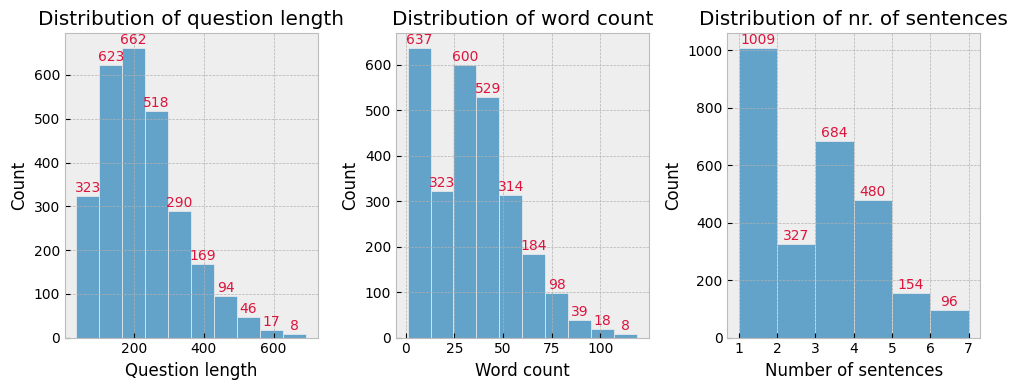

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

##### Get English dataset ######
# df = df[df['Language'] == 'en']

# Plot for 'length' column
sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0])
axes[0].set_title('Distribution of question length')
axes[0].set_xlabel('Question length')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'wordcount' column
sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1])
axes[1].set_title('Distribution of word count')
axes[1].set_xlabel('Word count')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'nr_sentences' column
sns.histplot(df['Nr_sentences'], kde=False, bins=6, ax=axes[2])
axes[2].set_title('Distribution of nr. of sentences')
axes[2].set_xlabel('Number of sentences')
axes[2].set_xticks(np.arange(1,8,1))
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

plt.tight_layout()
plt.show()


In [74]:
# # Create FacetGrid
# g = sns.FacetGrid(df, col='Language', col_wrap=6, height=4)

# # Plot for 'Length' column
# g.map_dataframe(sns.histplot, x='Length', kde=False, bins=10)
# g.set_xlabels('Length')
# plt.tight_layout()
# plt.show()

# # Plot for 'Wordcount' column
# g.map_dataframe(sns.histplot, x='Wordcount', kde=False, bins=10)
# g.set_xlabels('Word count')
# plt.tight_layout()
# plt.show()

# # Plot for 'Nr_sentences' column
# g.map_dataframe(sns.histplot, x='Nr_sentences', kde=False, bins=10)
# g.set_xlabels('Nr of sentences')
# plt.tight_layout()
# plt.show()

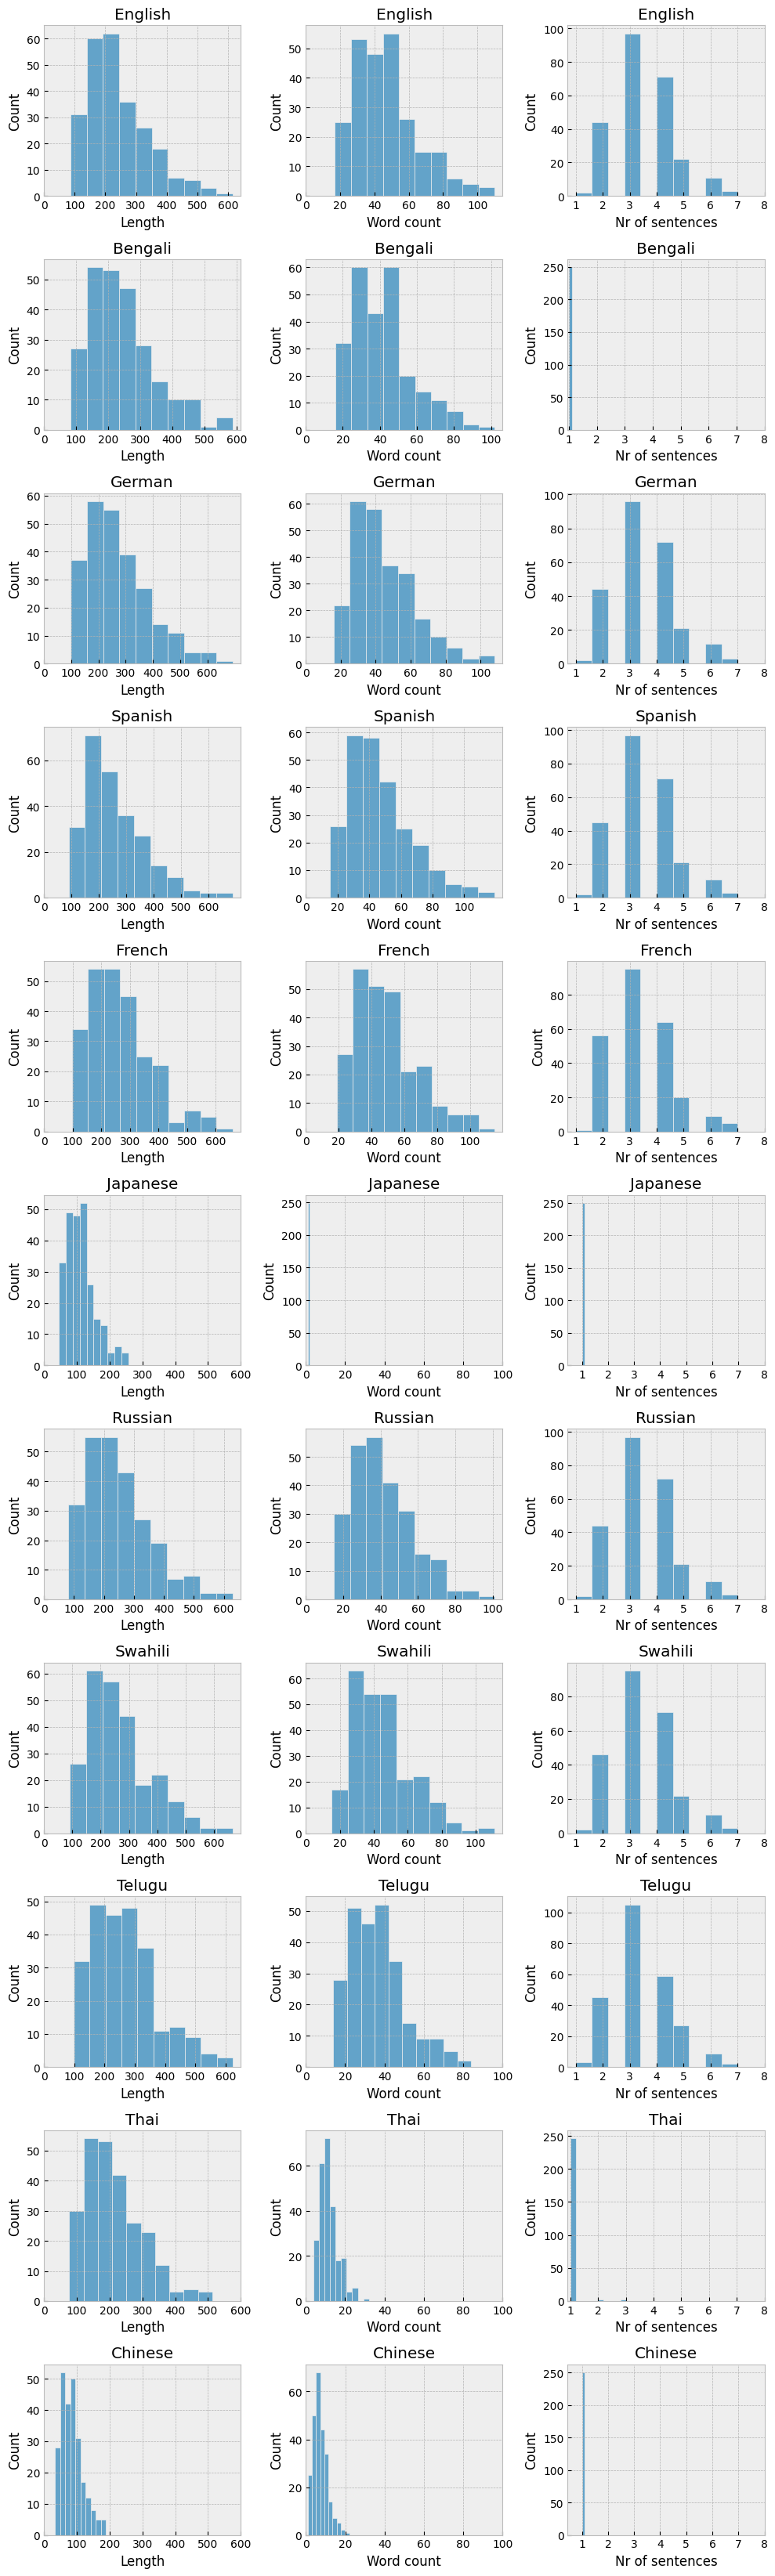

In [73]:
# Create FacetGrid with one row per language
languages = df['Language'].unique()
num_languages = len(languages)
num_cols = 3  

fig, axes = plt.subplots(num_languages, num_cols, figsize=(10, 3*num_languages))

# Iterate over each language and create subplots
for i, language in enumerate(languages):

    lang_df = df[df['Language'] == language]
    
    # Plot 'Length'
    ax = axes[i][0]
    sns.histplot(data=lang_df, x='Length', kde=False, bins=10, ax=ax)
    ax.set_xlabel('Length')
    ax.set_title(f'{language}')
    ax.set_xticks(np.arange(0,700,100))
    
    # Plot 'Wordcount'
    ax = axes[i][1]
    sns.histplot(data=lang_df, x='Wordcount', kde=False, bins=10, ax=ax)
    ax.set_xlabel('Word count')
    ax.set_title(f'{language}')
    ax.set_xticks(np.arange(0,120,20))
    
    # Plot 'Nr_sentences'
    ax = axes[i][2]
    sns.histplot(data=lang_df, x='Nr_sentences', kde=False, bins=10, ax=ax)
    ax.set_xlabel('Nr of sentences')
    ax.set_title(f'{language}')
    ax.set_xticks(np.arange(1,8,1))

plt.tight_layout()
plt.show()


### 2.1.2 XCOPA benchmark 
- question length, word count, nr sentences, nr of tokens (by llama-2 model)

#### Data loading

In [87]:
dataset_en = load_dataset("pkavumba/balanced-copa")      
dataset_ht = load_dataset("xcopa","ht")     
dataset_id = load_dataset("xcopa","id")     
dataset_it = load_dataset("xcopa","it")     
dataset_qu = load_dataset("xcopa","qu")     
dataset_sw = load_dataset("xcopa","sw")     
dataset_ta = load_dataset("xcopa","ta")     
dataset_tr = load_dataset("xcopa","tr")     
dataset_et = load_dataset("xcopa","et")     
dataset_th = load_dataset("xcopa","th")
dataset_vi = load_dataset("xcopa","vi")    
dataset_zh = load_dataset("xcopa","zh")    

In [92]:
data = {'Language' : ["English"]*500+["Haitian Creole"]*500 + ["Indonesian"]*500 + ["Italian"]*500 + ["Quechuan"]*500 + ["Swahili"]*500 + ["Tamil"]*500 + ["Turkish"]*500 + ["Estonian"]*500 + ["Thai"]*500 + ["Vietnamese"]*500+["Chinese"]*500,
        'Premise': dataset_en["test"]["premise"] + dataset_ht["test"]["premise"] + dataset_id["test"]["premise"] + dataset_it["test"]["premise"] + dataset_qu["test"]["premise"] + dataset_sw["test"]["premise"] + dataset_ta["test"]["premise"] + dataset_tr["test"]["premise"] + dataset_et["test"]["premise"] + dataset_th["test"]["premise"] + dataset_vi["test"]["premise"] + dataset_zh["test"]["premise"],
        'Choice1': dataset_en["test"]["choice1"] + dataset_ht["test"]["choice1"] + dataset_id["test"]["choice1"] + dataset_it["test"]["choice1"] + dataset_qu["test"]["choice1"] + dataset_sw["test"]["choice1"] + dataset_ta["test"]["choice1"] + dataset_tr["test"]["choice1"] + dataset_et["test"]["choice1"] + dataset_th["test"]["choice1"] + dataset_vi["test"]["choice1"] + dataset_zh["test"]["choice1"],
        'Choice2': dataset_en["test"]["choice2"] + dataset_ht["test"]["choice2"] + dataset_id["test"]["choice2"] + dataset_it["test"]["choice2"] + dataset_qu["test"]["choice2"] + dataset_sw["test"]["choice2"] + dataset_ta["test"]["choice2"] + dataset_tr["test"]["choice2"] + dataset_et["test"]["choice2"] + dataset_th["test"]["choice2"] + dataset_vi["test"]["choice2"] + dataset_zh["test"]["choice2"],
        'Question': dataset_en["test"]["question"] + dataset_ht["test"]["question"] + dataset_id["test"]["question"] + dataset_it["test"]["question"] + dataset_qu["test"]["question"] + dataset_sw["test"]["question"] + dataset_ta["test"]["question"] + dataset_tr["test"]["question"] + dataset_et["test"]["question"] + dataset_th["test"]["question"] + dataset_vi["test"]["question"] + dataset_zh["test"]["question"],
        'Label': dataset_en["test"]["label"] + dataset_ht["test"]["label"] + dataset_id["test"]["label"] + dataset_it["test"]["label"] + dataset_qu["test"]["label"] + dataset_sw["test"]["label"] + dataset_ta["test"]["label"] + dataset_tr["test"]["label"] + dataset_et["test"]["label"] + dataset_th["test"]["label"] + dataset_vi["test"]["label"] + dataset_zh["test"]["label"]}

df = pd.DataFrame(data=data)

length_premise = []
wordcount_premise = []
sentencecount_premise = []
    
for question in df["Question"]:
    length_premise.append(len(question))
    wordcount_premise.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount_premise.append(len(sentences))

length_choice1 = []
wordcount_choice1 = []
sentencecount_choice1 = []
    
for question in df["Question"]:
    length_choice1.append(len(question))
    wordcount_choice1.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount_choice1.append(len(sentences))

length_choice2 = []
wordcount_choice2 = []
sentencecount_choice2 = []
    
for question in df["Question"]:
    length_choice2.append(len(question))
    wordcount_choice2.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount_choice2.append(len(sentences))

df['Length_premise'] = length_premise
df['Wordcount_premise'] = wordcount_premise
df['Nr_sentences_premise'] = sentencecount_premise

df['Length_choice1'] = length_choice1
df['Wordcount_choice1'] = wordcount_choice1
df['Nr_sentences_choice1'] = sentencecount_choice1

df['Length_choice2'] = length_choice2
df['Wordcount_choice2'] = wordcount_choice2
df['Nr_sentences_choice2'] = sentencecount_choice2

df

,Language,Premise,Choice1,Choice2,Question,Label,Length_premise,Wordcount_premise,Nr_sentences_premise,Length_choice1,Wordcount_choice1,Nr_sentences_choice1,Length_choice2,Wordcount_choice2,Nr_sentences_choice2
0,English,The item was packaged in bubble wrap.,It was fragile.,It was small.,cause,0,5,1,1,5,1,1,5,1,1
1,English,I emptied my pockets.,I retrieved a ticket stub.,I found a weapon.,effect,0,6,1,1,6,1,1,6,1,1
2,English,Termites invaded the house.,The termites disappeared from the house.,The termites ate through the wood in the house.,effect,1,6,1,1,6,1,1,6,1,1
3,English,The travelers reached the border.,The patrol agent checked their passports.,The patrol agent accused them of smuggling.,effect,0,6,1,1,6,1,1,6,1,1
4,English,The office was closed.,It was a holiday.,It was summer.,cause,0,5,1,1,5,1,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Chinese,赛跑者感觉到他的竞争对手在逼近。,他退出了比赛。,他加快了步伐。,effect,1,6,1,1,6,1,1,6,1,1
5996,Chinese,我仔细考虑了这个问题。,我征求了意见。,我想出了一个解决办法。,effect,1,6,1,1,6,1,1,6,1,1
5997,Chinese,旅行者走在摇摇欲坠的吊桥上。,他感到害怕。,他欣喜若狂。,effect,0,6,1,1,6,1,1,6,1,1
5998,Chinese,那人预料到球队会获胜。,他会见了他的朋友看比赛。,他和朋友们打赌。,effect,1,6,1,1,6,1,1,6,1,1


## 2.2. Large language models

### 2.2.1 Machine translation

Machine translation: NLLB-200-3.3b

Languages:
Metrics: BLEU, spBLEU, ChrF++

Available languages in nllb-200-3.3b

Acehnese (Latin script)
Arabic (Iraqi/Mesopotamian)
Arabic (Yemen)
Arabic (Tunisia)
Afrikaans
Arabic (Jordan)
Akan
Amharic
Arabic (Lebanon)
Arabic (MSA)
Arabic (Modern Standard Arabic)
Arabic (Saudi Arabia)
Arabic (Morocco)
Arabic (Egypt)
Assamese
Asturian
Awadhi
Aymara
Crimean Tatar
Welsh
Danish
German
French
Friulian
Fulfulde
Dinka(Rek)
Dyula
Dzongkha
Greek
English
Esperanto
Estonian
Basque
Ewe
Faroese
Iranian Persian
Icelandic
Italian
Javanese
Japanese
Kabyle
Kachin | Jinghpo
Kamba
Kannada
Kashmiri (Arabic script)
Kashmiri (Devanagari script)
Georgian
Kanuri (Arabic script)
Kanuri (Latin script)
Kazakh
Kabiye
Thai
Khmer
Kikuyu
South Azerbaijani
North Azerbaijani
Bashkir
Bambara
Balinese
Belarusian
Bemba
Bengali
Bhojpuri
Banjar (Latin script)
Tibetan
Bosnian
Buginese
Bulgarian
Catalan
Cebuano
Czech
Chokwe
Central Kurdish
Fijian
Finnish
Fon
Scottish Gaelic
Irish
Galician
Guarani
Gujarati
Haitian Creole
Hausa
Hebrew
Hindi
Chhattisgarhi
Croatian
Hugarian
Armenian
Igobo
IIocano
Indonesian
Kinyarwanda
Kyrgyz
Kimbundu
Konga
Korean
Kurdish (Kurmanji)
Lao
Latvian (Standard)
Ligurian
Limburgish
Lingala
Lithuanian
Lombard
Latgalian
Luxembourgish
Luba-Kasai
Ganda
Dholuo
Mizo

In [235]:
#   ace_Arab, ace_Latn, acm_Arab, acq_Arab, aeb_Arab, afr_Latn, ajp_Arab,
#   aka_Latn, amh_Ethi, apc_Arab, arb_Arab, ars_Arab, ary_Arab, arz_Arab,
#   asm_Beng, ast_Latn, awa_Deva, ayr_Latn, azb_Arab, azj_Latn, bak_Cyrl,
#   bam_Latn, ban_Latn,bel_Cyrl, bem_Latn, ben_Beng, bho_Deva, bjn_Arab, bjn_Latn,
#   bod_Tibt, bos_Latn, bug_Latn, bul_Cyrl, cat_Latn, ceb_Latn, ces_Latn,
#   cjk_Latn, ckb_Arab, crh_Latn, cym_Latn, dan_Latn, deu_Latn, dik_Latn,
#   dyu_Latn, dzo_Tibt, ell_Grek, eng_Latn, epo_Latn, est_Latn, eus_Latn,
#   ewe_Latn, fao_Latn, pes_Arab, fij_Latn, fin_Latn, fon_Latn, fra_Latn,
#   fur_Latn, fuv_Latn, gla_Latn, gle_Latn, glg_Latn, grn_Latn, guj_Gujr,
#   hat_Latn, hau_Latn, heb_Hebr, hin_Deva, hne_Deva, hrv_Latn, hun_Latn,
#   hye_Armn, ibo_Latn, ilo_Latn, ind_Latn, isl_Latn, ita_Latn, jav_Latn,
#   jpn_Jpan, kab_Latn, kac_Latn, kam_Latn, kan_Knda, kas_Arab, kas_Deva,
#   kat_Geor, knc_Arab, knc_Latn, kaz_Cyrl, kbp_Latn, kea_Latn, khm_Khmr,
#   kik_Latn, kin_Latn, kir_Cyrl, kmb_Latn, kon_Latn, kor_Hang, kmr_Latn,
#   lao_Laoo, lvs_Latn, lij_Latn, lim_Latn, lin_Latn, lit_Latn, lmo_Latn,
#   ltg_Latn, ltz_Latn, lua_Latn, lug_Latn, luo_Latn, lus_Latn, mag_Deva,
#   mai_Deva, mal_Mlym, mar_Deva, min_Latn, mkd_Cyrl, plt_Latn, mlt_Latn,
#   mni_Beng, khk_Cyrl, mos_Latn, mri_Latn, zsm_Latn, mya_Mymr, nld_Latn,
#   nno_Latn, nob_Latn, npi_Deva, nso_Latn, nus_Latn, nya_Latn, oci_Latn,
#   gaz_Latn, ory_Orya, pag_Latn, pan_Guru, pap_Latn, pol_Latn, por_Latn,
#   prs_Arab, pbt_Arab, quy_Latn, ron_Latn, run_Latn, rus_Cyrl, sag_Latn,
#   san_Deva, sat_Beng, scn_Latn, shn_Mymr, sin_Sinh, slk_Latn, slv_Latn,
#   smo_Latn, sna_Latn, snd_Arab, som_Latn, sot_Latn, spa_Latn, als_Latn,
#   srd_Latn, srp_Cyrl, ssw_Latn, sun_Latn, swe_Latn, swh_Latn, szl_Latn,
#   tam_Taml, tat_Cyrl, tel_Telu, tgk_Cyrl, tgl_Latn, tha_Thai, tir_Ethi,
#   taq_Latn, taq_Tfng, tpi_Latn, tsn_Latn, tso_Latn, tuk_Latn, tum_Latn,
#   tur_Latn, twi_Latn, tzm_Tfng, uig_Arab, ukr_Cyrl, umb_Latn, urd_Arab,
#   uzn_Latn, vec_Latn, vie_Latn, war_Latn, wol_Latn, xho_Latn, ydd_Hebr,
#   yor_Latn, yue_Hant, zho_Hans, zho_Hant, zul_Latn 

In [3]:
# load the metrics dataset
nllb_metrics = pd.read_csv('./metrics.csv', sep=',')
nllb_metrics = nllb_metrics[nllb_metrics['direction'].str[:3] == 'eng']
nllb_metrics[110:130]

##### select relevant translations that we are going to use

,direction,chrf++
201,eng_Latn-luo_Latn,39.0
202,eng_Latn-lus_Latn,37.0
203,eng_Latn-lvs_Latn,51.8
204,eng_Latn-mag_Deva,55.7
205,eng_Latn-mai_Deva,44.1
206,eng_Latn-mal_Mlym,49.6
207,eng_Latn-mar_Deva,47.1
208,eng_Latn-min_Latn,50.6
209,eng_Latn-mkd_Cyrl,59.9
210,eng_Latn-mlt_Latn,64.0


In [7]:
# # the metrics from the new MoE model (54.5B)
# nllb_metrics = pd.read_csv('./metrics_moe.csv', sep=',')
# nllb_metrics = nllb_metrics[nllb_metrics['direction'].str[:3] == 'eng']
# nllb_metrics

### 2.2.2 Chain-of-thought experiments
Llama-2-7b-chat

![image](Llama-2-languages.png)

Figure 3: Distribution the languages in the pretraining corpus of Llama-2 (Toevron et al., 2023).


In [236]:
# load model here? or not needed for eda?

This research aims to test the effect of using languages in CoT reasoning that are more related to the target language than English. In order to test this, the main results on the MGSM benchmark for CoT in the native language as well as CoT in English are set as baseline performance. These results are extracted from Shi et al. (2022), Qin et al. (2023) and Huang et al. (2023). 

Here, “Direct” denotes the original input request will be given to model directly. “Native-CoT” signifies that the model generates inference steps in the same language as the input. “En-CoT” indicates the given non-English input request and returned with English CoT result.Translate-En” denotes we translate non-English input requests into English by Google translation API. **remove this one?**

In [ ]:
data = {'Paper':    ["Shi et al., 2022"]*88 + ["Qin et al., 2023"]*44 + ["Huang et al., 2023"]*55, 
        'Model':    ["GPT-3 (text-davinci-002)"]*44 + 
                        ["PaLM-540B"]*44 + 
                        ["GPT-3.5 (gpt-3.5-turbo)"]*44 + 
                        ["GPT-3 (text-davinci-003)"]*22 +
                        ["GPT-3.5 (gpt-3.5-turbo)"]*22 +
                        ["Llama-2-7b-chat-hf"]*11, 
        'Method':   ["Direct"]*11 + ["Native-CoT"]*11 + ["En-CoT"]*11 + ["Translate-En"]*11 + 
                    ["Direct"]*11 + ["Native-CoT"]*11 + ["En-CoT"]*11 + ["Translate-En"]*11 +
                    ["Direct"]*11 + ["Native-CoT"]*11 + ["En-CoT"]*11 + ["Translate-En"]*11 +
                    ["Basic prompt"]*55, 
        'Few-shot': ["Few-shot (6)"]*132 + ["Zero-shot"]*11 + ["Few-shot"]*11 + ["Zero-shot"]*11 + ["Few-shot"]*11 + ["Zero-shot"]*11,
        'Language': ["en", "bn", "de", "es", "fr", "ja", "ru", "sw", "te", "th", "zh"]*12 +
                    ["en", "de", "ru", "fr", "zh", "es", "ja", "sw", "th", "bn", "te"]*5, 
        'Accuracy': [16, 4.4, 14.8, 17.2, 16.8, 11.2, 12.4, 8.8, 0.8, 8.8, 18.0, 53.6, 6.4, 36.0, 40.4, 37.6, 26.0, 28.4, 11.2, 0.4, 10.8, 40.0, 53.6, 9.6, 44.0, 44.8, 46.0, 32.4, 28.4, 20.8, 5.6, 19.6, 40.8, 53.6, 41.2, 46.4, 51.6, 46.4, 44.8, 48.8, 37.6, 42.8, 41.2, 47.2] +
                    [22.0, 17.2, 18.8, 20.0, 19.6, 16.0, 22.0, 15.6, 17.6, 16.8, 19.2, 62.4, 46.0, 49.2, 56.8, 46.4, 40.0, 48.4, 35.2, 45.6, 52.8, 46.8, 62.4, 46.4, 53.6, 58.0, 51.2, 49.6, 55.6, 44.4, 46.8, 49.6, 46.0, 62.4, 53.2, 57.2, 60.0, 55.2, 50.0, 59.6, 51.2, 49.6, 50.8, 55.6] +
                    [None,33.6, 56.0, 61.2, 62.0, 52.8, 62.0, 48.0, 7.6, 42.4, 60.0, None, 26.4, 70.0, 70.4, 64.4, 52.8, 62.4, 54.0, 10.4, 40.0, 59.6, None, 50.0, 73.6, 69.6, 70.0, 60.4, 65.6, 55.2, 22.0, 48.0, 63.2, None, 66.4, 75.6, 74.4, 72.4, 66.0, 72.8, 69.6, 58.0, 57.6, 71.6] +
                    [19.2, 12.8, 15.6, 16.4, 15.2, 13.6, 12.8, 7.2, 8.8, 11.6, 4.4, 60.4, 45.6, 51.6, 45.6, 38.8, 51.6, 37.6, 48.8, 30.4, 43.6, 46.8] +
                    [32.0, 24.8, 28.0, 31.6, 22.0, 29.2, 22.4, 24.4, 16.8, 18.0, 7.6, 82.8, 69.2, 71.6, 72.4, 46.8, 71.2, 56.0, 60.0, 44.0, 62.4, 56.6] +
                    [58.8, 48.0, 47.2, 45.6, 39.6, 50.4, 39.2, 10.0, 13.6, 17.2, 5.2]}

df = pd.DataFrame(data=data)
df.tail(22)

# # Create a FacetGrid
# g = sns.FacetGrid(df, col='Method', row='Model', hue='Language', margin_titles=True)
# g.map(sns.barplot, 'Language', 'Accuracy', errorbar=None)

# # Add title and labels
# g.fig.subplots_adjust(top=0.9)  # Adjust the location of the title
# g.fig.suptitle('Accuracy by method, model, and language')

# # Rotate x-axis labels for better readability
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # Adjust legend
# g.add_legend(title='Language', bbox_to_anchor=(1, 1), loc='upper left')

# # Show plot
# plt.tight_layout()
# plt.show()

## 2.3 Language similarity

WALS, script

- Genus, family plot 
- All features, missing values
- All features chapters
- script
- 


#### Data loading

In [ ]:
# load the script dataset
scriptdata = pd.read_csv('../WALS/script.csv', sep=';')

# load the WALS dataset
walsdata = pd.read_csv('../WALS/language.csv', sep=',')

#### Data cleaning

- seperate cleaning of scriptdata
- merge scriptdata with WALSdata
- select relevant languages
- select relevant features

The language script data is in table form where some rows have sub rows for multiple script values. When loading the .csv file, this results in a seperate row below the language row for the script value. The following code adds the language name and code of the top row and adds it to the rows with missing values.

In [129]:
# add the language name and code of the above row to the rows with missing values
for index, row in scriptdata.iterrows():
    if pd.isna(row['Language']):
        scriptdata.at[index, 'Language'] = scriptdata.at[index - 1, 'Language']
        scriptdata.at[index, 'Code'] = scriptdata.at[index - 1, 'Code']

scriptdata = scriptdata.drop(columns=['ML','P','Code.1','MS']) # drop the unnecessary columns
scriptdata = scriptdata.groupby(['Language', 'Code'])['Script'].agg(', '.join).reset_index() # group the languages by name and add the different script types

scriptdata.rename(columns = {'Language':'Name'}, inplace = True) 

# Change names that differ in the nllb and wals naming code?
scriptdata.loc[scriptdata['Name'] == 'Bangla', 'Name'] = 'Bengali'
scriptdata.loc[scriptdata['Name'] == 'Chinese', 'Name'] = 'Mandarin'


In [206]:

walsdata_mgsm = walsdata.loc[walsdata['wals_code'].isin(['eng','ben','mnd','fre','ger','jpn','rus','spa','swa','tel','tha'])]

# join the script values to the WALS dataset based on the language name
walsdata_mgsm = pd.merge(walsdata_mgsm, scriptdata)
# walsdata_mgsm.info


In [226]:
# Hindi, Nepali, Bengali, Telugu, Tamil
# Cantonese, Korean, Chinese, Japanese
# Vietnamese, Lao, Thai, Khmer, Burmese
# Malay, Indonesian, Balinese, Philippino
# Dutch, Afrikaans, Frisian, German, 
# Norwegian, Finnish, Danish, Swedish
# Italian, French, Spanish, Catalan, Portuguese
# Russian, Ukrainian, Polish, Slovenian, Serbian, Czech, Hungarian, Bulgarian, Croatian, Estonian
# Swahili, Zulu
# Haitian Creole
# Eastern Apurímac Quechua
# Turkish, Arabic

# Also needs to be available in the language set of the nllb-model
walsdata_test = walsdata.loc[walsdata['wals_code'].isin(['eng','hin','nep','ben','tel', 'tml', 'cnt','kor','mnd','jpn','vie','lao','tha','khm','brm','mly','ind','bal','phi','nld','afr','fri','ger','nor','fin','dsh','ctl','por','rus','ukr','pol','slo','scr','cze','hun','bul','swa','zul'])]


#### Exploring the data
- Plots of language features
- Missing data
- Language similarity?

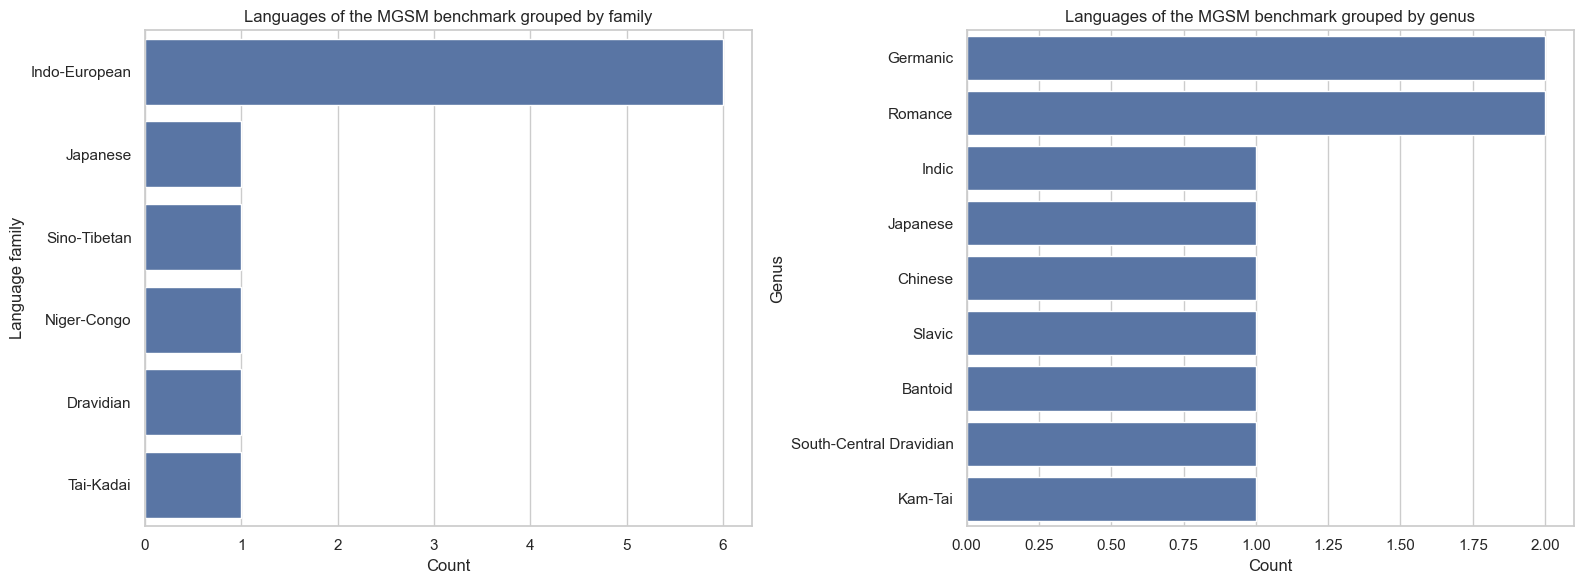

In [186]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="family", data=walsdata_mgsm, order=walsdata_mgsm['family'].value_counts().index, ax=axes[0])
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Language family")
axes[0].set_title("Languages of the MGSM benchmark grouped by family")

# Plot 2: Languages grouped by 'genus'
sns.countplot(y="genus", data=walsdata_mgsm, order=walsdata_mgsm['genus'].value_counts().index, ax=axes[1])
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Genus")
axes[1].set_title("Languages of the MGSM benchmark grouped by genus")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


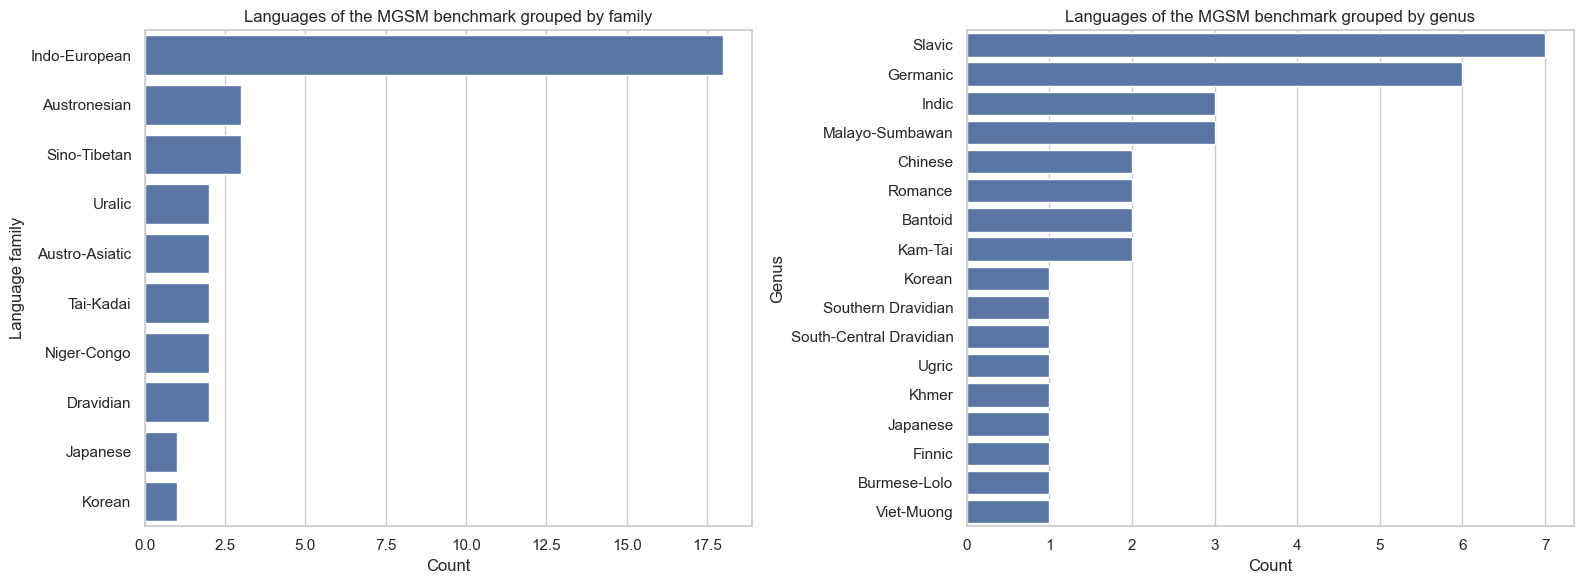

In [225]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="family", data=walsdata_test, order=walsdata_test['family'].value_counts().index, ax=axes[0])
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Language family")
axes[0].set_title("Languages of the MGSM benchmark grouped by family")

# Plot 2: Languages grouped by 'genus'
sns.countplot(y="genus", data=walsdata_test, order=walsdata_test['genus'].value_counts().index, ax=axes[1])
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Genus")
axes[1].set_title("Languages of the MGSM benchmark grouped by genus")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

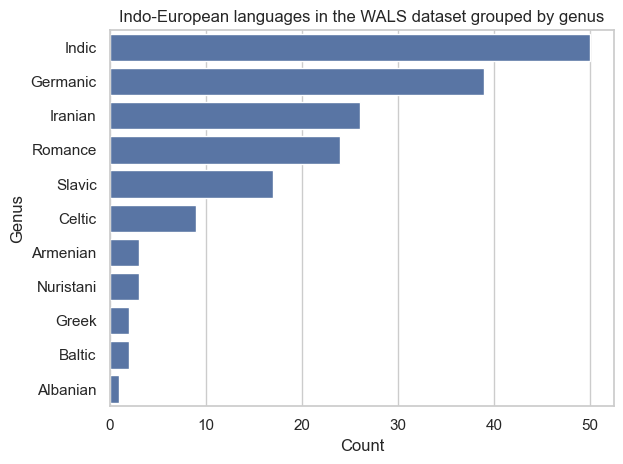

In [232]:
# Plot 1: Languages grouped by 'family'

sns.countplot(y="genus", data=walsdata_indo_eur, order=walsdata_indo_eur['genus'].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Genus")
plt.title("Indo-European languages in the WALS dataset grouped by genus")

# Show the plot
plt.tight_layout()
plt.show()

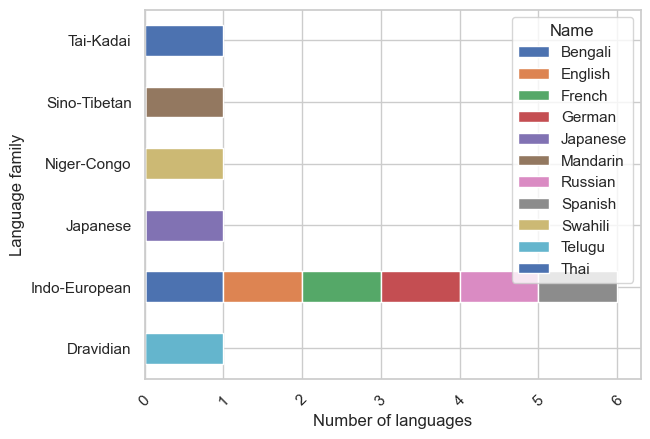

In [181]:
sns.set(style="whitegrid")

# Pivot the DataFrame so that each language becomes a separate column
pivoted_data = walsdata_mgsm.pivot_table(index='family', columns='Name', aggfunc='size', fill_value=0)

# Create the stacked bar chart
pivoted_data.plot(kind='barh', stacked=True)

# Add axis titles
plt.xlabel('Number of languages')
plt.ylabel('Language family')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


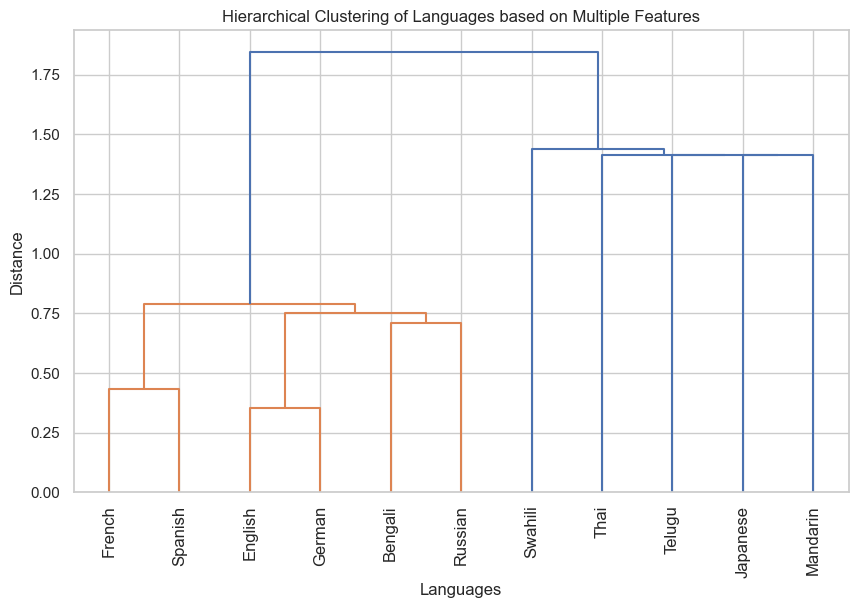

In [194]:

# Assuming 'walsdata_mgsm' is your DataFrame with language data
encoded_features = pd.get_dummies(walsdata_mgsm[['family', 'genus', 'Script']])

# Combine encoded features with 'family' column
all_features = pd.concat([encoded_features, pd.get_dummies(walsdata_mgsm['family'])], axis=1)

from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity matrix
similarity_matrix = cosine_similarity(all_features)

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate hierarchical clustering
clusters = linkage(similarity_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(clusters, labels=walsdata_mgsm['Name'].values, leaf_rotation=90)
plt.xlabel('Languages')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering of Languages based on Multiple Features')
plt.show()

In [56]:
# find a subset of the wals dataset of languages that are in the nllb-200-3.3b model.
# cannot find bengali or chinese. need to add iso-2 country codes
walsdata_nllb1 = walsdata.loc[walsdata['wals_code'].isin(['ace','acm','acq','aeb','af','ajp','ak','als','am','apc','ar','ars','ary','arz','as','ast','awa','ayr','azb','azj','ba','bm','ban','be','bem','bn','bho','bjn','bo','bs','bug','bg','ca','ceb','cs','cjk','ckb','crh','cy','da','de','dik','dyu','dz','el','en','eo','et','eu','ee','fo','fj','fi','fon','fr','fur','fuv','gaz','gd','ga','gl','gn','gu','ht','ha','he','hi','hne','hr','hu','hy','ig','ilo','id','is','it','jv','ja','kab','kac','kam','kn','ks','ka','kk',' kbp','kea','khk','km','ki','rw','ky','kmb','kmr','knc','kg','ko','lo','lij','li','ln','lt','lmo','ltg','lb','lua','lg','luo','lu','mag','mai','ml','mar','min','mk','mt','mni','mos','mi','my','nl','nn','nb','npi','nso','nus','ny','oc','ory','pag','pa','pap','pbt','pes','plt','pl','pt','prs','quy','ro','rn','ru','sg','sa','sat','scn','shn','si','sk','sl','sm','sn','sd','so','st','es','sc','sr','ss','su','sv','swh','szl','ta','taq','tt','te','tg','tl','th','ti','tpi','tn','ts','tk','tum','tr','tw','tzm','ug','uk','umb','ur','uzn','vec','vi','war','wo','xh','ydd','yo','yue','zh','zsm','zu'])]
walsdata_nllb2 = walsdata.loc[walsdata['Code'].isin(['ace','acm','acq','aeb','af','ajp','ak','als','am','apc','ar','ars','ary','arz','as','ast','awa','ayr','azb','azj','ba','bm','ban','be','bem','bn','bho','bjn','bo','bs','bug','bg','ca','ceb','cs','cjk','ckb','crh','cy','da','de','dik','dyu','dz','el','en','eo','et','eu','ee','fo','fj','fi','fon','fr','fur','fuv','gaz','gd','ga','gl','gn','gu','ht','ha','he','hi','hne','hr','hu','hy','ig','ilo','id','is','it','jv','ja','kab','kac','kam','kn','ks','ka','kk',' kbp','kea','khk','km','ki','rw','ky','kmb','kmr','knc','kg','ko','lo','lij','li','ln','lt','lmo','ltg','lb','lua','lg','luo','lu','mag','mai','ml','mar','min','mk','mt','mni','mos','mi','my','nl','nn','nb','npi','nso','nus','ny','oc','ory','pag','pa','pap','pbt','pes','plt','pl','pt','prs','quy','ro','rn','ru','sg','sa','sat','scn','shn','si','sk','sl','sm','sn','sd','so','st','es','sc','sr','ss','su','sv','swh','szl','ta','taq','tt','te','tg','tl','th','ti','tpi','tn','ts','tk','tum','tr','tw','tzm','ug','uk','umb','ur','uzn','vec','vi','war','wo','xh','ydd','yo','yue','zh','zsm','zu']) ]
walsdata_nllb3 = walsdata.loc[walsdata['iso_code'].isin(['ace','acm','acq','aeb','af','ajp','ak','als','am','apc','ar','ars','ary','arz','as','ast','awa','ayr','azb','azj','ba','bm','ban','be','bem','bn','bho','bjn','bo','bs','bug','bg','ca','ceb','cs','cjk','ckb','crh','cy','da','de','dik','dyu','dz','el','en','eo','et','eu','ee','fo','fj','fi','fon','fr','fur','fuv','gaz','gd','ga','gl','gn','gu','ht','ha','he','hi','hne','hr','hu','hy','ig','ilo','id','is','it','jv','ja','kab','kac','kam','kn','ks','ka','kk',' kbp','kea','khk','km','ki','rw','ky','kmb','kmr','knc','kg','ko','lo','lij','li','ln','lt','lmo','ltg','lb','lua','lg','luo','lu','mag','mai','ml','mar','min','mk','mt','mni','mos','mi','my','nl','nn','nb','npi','nso','nus','ny','oc','ory','pag','pa','pap','pbt','pes','plt','pl','pt','prs','quy','ro','rn','ru','sg','sa','sat','scn','shn','si','sk','sl','sm','sn','sd','so','st','es','sc','sr','ss','su','sv','swh','szl','ta','taq','tt','te','tg','tl','th','ti','tpi','tn','ts','tk','tum','tr','tw','tzm','ug','uk','umb','ur','uzn','vec','vi','war','wo','xh','ydd','yo','yue','zh','zsm','zu'])]

walsdata_nllb = pd.concat([walsdata_nllb1, walsdata_nllb2, walsdata_nllb3])
len(walsdata_nllb.index)


153

### References

1. Cobbe, K., Kosaraju, V., Bavarian, M., Chen, M., Jun, H., Kaiser, L., ... & Schulman, J. (2021). Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168.
2. Shi, F., Suzgun, M., Freitag, M., Wang, X., Srivats, S., Vosoughi, S., ... & Wei, J. (2022). Language models are multilingual chain-of-thought reasoners. arXiv preprint arXiv:2210.03057.
3. Qin, L., Chen, Q., Wei, F., Huang, S., & Che, W. (2023). Cross-lingual prompting: Improving zero-shot chain-of-thought reasoning across languages. arXiv preprint arXiv:2310.14799.
4. Huang, H., Tang, T., Zhang, D., Zhao, W. X., Song, T., Xia, Y., & Wei, F. (2023). Not All Languages Are Created Equal in LLMs: Improving Multilingual Capability by Cross-Lingual-Thought Prompting. arXiv preprint arXiv:2305.07004.
5. Ponti, E. M., Glavaš, G., Majewska, O., Liu, Q., Vulić, I., & Korhonen, A. (2020). XCOPA: A multilingual dataset for causal commonsense reasoning. arXiv preprint arXiv:2005.00333.
6. Roemmele, M., Bejan, C. A., & Gordon, A. S. (2011, March). Choice of plausible alternatives: An evaluation of commonsense causal reasoning. In 2011 AAAI Spring Symposium Series.
7. Dryer, Matthew S. & Haspelmath, Martin (eds.) 2013. WALS Online (v2020.3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7385533 (Available online at https://wals.info, Accessed on 2024-01-30.)
8. Unicode CLDR (2023). Languages and scripts. Retrieved from https://www.unicode.org/cldr/charts/44/supplemental/languages_and_scripts.html
9. Costa-jussà, M. R., Cross, J., Çelebi, O., Elbayad, M., Heafield, K., Heffernan, K., ... & NLLB Team. (2022). No language left behind: Scaling human-centered machine translation. arXiv preprint arXiv:2207.04672.